## importing the required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

####  data source - https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

In [3]:
## load train data i.e a CSV containing the customers for whom loan eligibility is known as 'Loan_Status'

train = pd.read_csv('train.csv')

In [4]:
## get basic overview of train dataset
## shape(i.e. no. of rows, columns) and first few rows of the train data

display(train.shape, train.head())

(614, 13)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
## check info() 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
## inferences from info() : 

## 1. We can see the RangeIndex tells there are 614 entries(rows) , but when we see column wise Non-Null Count, 
      # we see that not all columns have the same no. of Non-Null Values as the total number of rows in the dataset. 
      # So we can say that the data must have a few null values which we will further analyse

## 2. Categorical columns : Gender, Married, Dependents, Education, Self_Employed, Property_Area, Loan_Status(target column)
##    [Note: The column 'Credit_History' might also be categorical (but is float64), so we'll analyse this too.]


In [7]:
## Check column wise null values count and % in train

pd.DataFrame(zip(train.isnull().sum(), train.isnull().sum()/len(train)*100), index=train.columns, 
             columns=['Null_count','Null_percent'])       

,Null_count,Null_percent
Loan_ID,0,0.000000
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Education,0,0.000000
Self_Employed,32,5.211726
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130


In [8]:
## Infer: 

#    No column has missing values more than 10%, so first thing that comes to mind is that we can delete the records having NaN
#    But we'll have to check how much total % of data it will amount to.

len(train[train.isna().any(axis=1)])/len(train)*100    ## 21.8% data (rows) will be lost, so it's not advisable to delete 
                                                                           # the records  rather we'll try to impute them

21.824104234527688

In [9]:
## LET'S START MISSING VALUE IMPUTATION:

In [10]:
# replacing NaN with mode for categorical columns - Gender, Married, Dependents, Self_Employed, Credit_History

train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

In [11]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
## LoanAmount is a continuous numerical data column, so we will not replace with mode, 
                              # let's try to find some correlation with other columns

In [13]:
train.corr()                      ## infer: LoanAmount has highest correlation with ApplicantIncome

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.018615
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,0.011134
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.001463
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.000445
Credit_History,-0.018615,0.011134,-0.001463,0.000445,1.000000


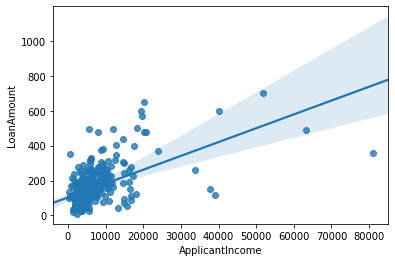

In [14]:
sns.regplot(x=train['ApplicantIncome'], y=train['LoanAmount'])       

## relationship is not clear (might be because of outliers or scaling issue)

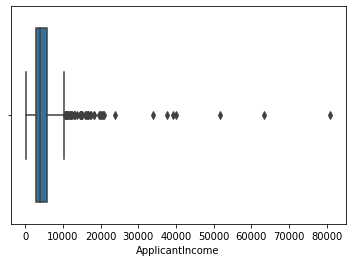

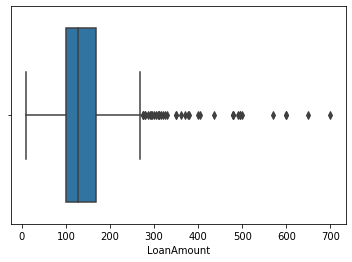

In [15]:
sns.boxplot(train['ApplicantIncome'])
plt.show()
sns.boxplot(train['LoanAmount'])
plt.show()     ## both have outliers

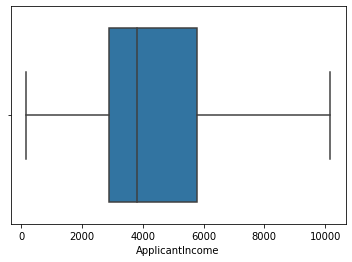

In [16]:
def outlier_treatment(data, *cols):
    for i in cols:
        q1,q3 = np.percentile(data[i],[25,75])
        iqr = q3-q1
        lower_fence = q1 - (1.5*iqr)
        upper_fence = q3 + (1.5*iqr)
        data[i] = data[i].apply(lambda x: upper_fence if x>upper_fence else lower_fence if x<lower_fence else x)
        
outlier_treatment(train, 'ApplicantIncome')   ## did not treat LoanAmount yet as it still has NaN values
sns.boxplot(train['ApplicantIncome'])

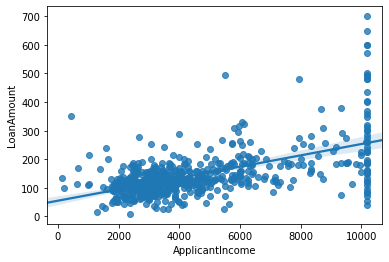

In [17]:
sns.regplot(x=train['ApplicantIncome'], y=train['LoanAmount'])    ## now we can better see that LoanAmount and
                                                                  ## ApplicantIncome have a positive relationship

In [18]:
## replacing the null values in LoanAmount by median

train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

In [19]:
train.isnull().sum()    ## so now we have got rid of all null values in the train dataset

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

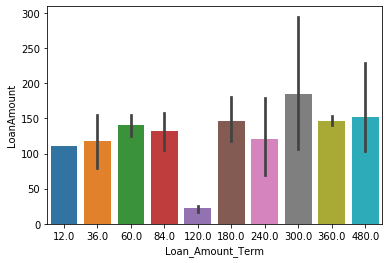

In [20]:
# We will try to find relation between Loan_Amount_Term and the LoanAmount
sns.barplot(x=train['Loan_Amount_Term'], y=train['LoanAmount'])                

## can't infer any particular relation b/w the two

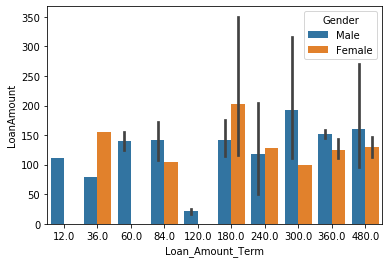

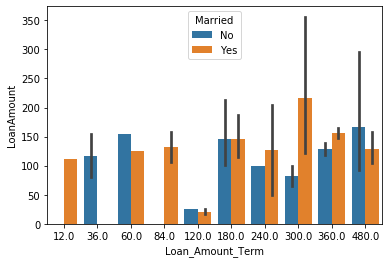

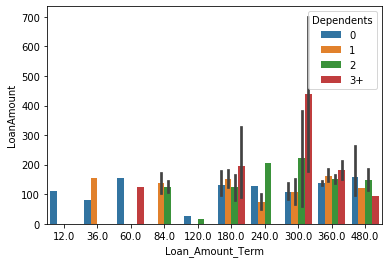

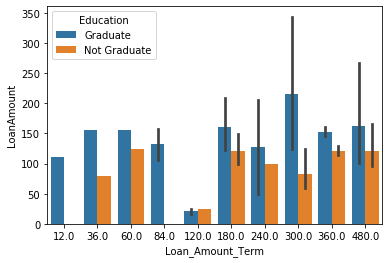

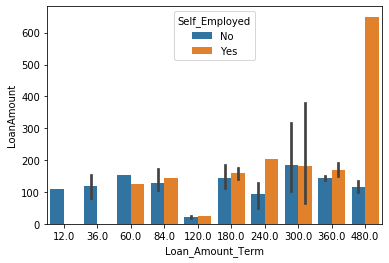

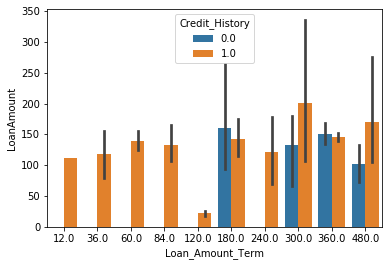

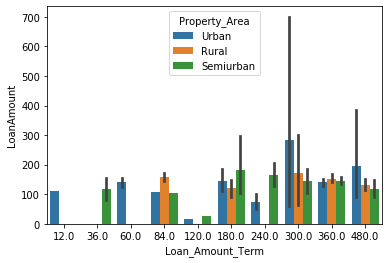

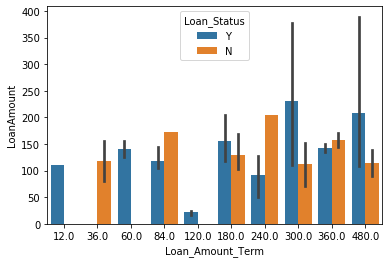

In [21]:
categorical_cols = ['Gender','Married','Dependents','Education','Self_Employed',
                    'Credit_History','Property_Area','Loan_Status']  # we'll include Credit_History in categorical_cols 
for i in categorical_cols:
    sns.barplot(x=train['Loan_Amount_Term'], y=train['LoanAmount'], hue=train[i])   
    plt.show()
    
## Same graph as above, with grouping by different categorical columns 

In [22]:
## infer: 
# 1. For records having Credit_History = 0, Loan_Amount_Term >=180
# 2. Self_Employed 'yes' records have loan term >= 60 months 

# Other than these, we are not getting a very clear picture w.r.t. Loan_Amount_Term

train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)  ## Replacing missing values with mode
train.isnull().sum()  ## all nulls are treated


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [23]:
## check for duplicates

train.duplicated().sum()    ## no duplicates

# train[train==' '].sum()  ## no blank spaces either

0

In [24]:
## UNIVARIATE ANALYSIS
display(train.head(2), train.dtypes)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N


Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [25]:
# First step for univariate analysis is to identify which columns are categorial and 
# which ones are numerical so that we can analyse them accordingly

# According to dtypes, the following seem to be numerical columns:
                            # ApplicantIncome        int64
                            # CoapplicantIncome    float64
                            # LoanAmount           float64
                            # Loan_Amount_Term     float64
                            # Credit_History       float64   --> (It is actually categorical data  
                                                                   # so we will deal with it accordingly)
                    
# Categorical columns:
                            # Gender                object
                            # Married               object
                            # Dependents            object
                            # Education             object
                            # Self_Employed         object
                            # Property_Area         object
                            # Loan_Status           object   ---> TARGET COLUMN

In [26]:
## Check for class - imbalance in target column

train['Loan_Status'].value_counts(normalize=True)  ## 68.73% Y and 31.27% N -- - That's approx. 70:30 ratio

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [27]:
train.describe()   ## gives count, mean, min, max, quantiles of *numerical* columns of the dataframe

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,4617.111564,1621.245798,145.752443,342.410423,0.855049
std,2479.851729,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,10171.250000,41667.000000,700.000000,480.000000,1.000000


In [28]:
## infer: Credit_History doesn't seem right as a numerical column as it has min=0 and max=1, so checking it's value_counts()

train['Credit_History'].value_counts()    

## It has two values 0.0 and 1.0 that depict whether credit history meets guidelines

1.0    525
0.0     89
Name: Credit_History, dtype: int64

In [29]:
# converting 'Credit_History' column to object type as it is a categorical column
train['Credit_History'] = train['Credit_History'].apply(lambda x: '1' if x==1.0 else '0' if x==0.0 else x)
train['Credit_History'].dtype   ## 'O' stands for object type

dtype('O')

In [53]:
## Categorical columns - Univariate

categorical_cols = ['Gender','Married','Dependents','Education','Self_Employed',
                    'Credit_History','Property_Area']  # we'll include Credit_History in categorical_cols 

for i in categorical_cols:
    print(train[i].value_counts(normalize=True),'\n')   ## look at proportions for each category for all categorical columns

Male      0.81759
Female    0.18241
Name: Gender, dtype: float64 

Yes    0.653094
No     0.346906
Name: Married, dtype: float64 

0     0.586319
1     0.166124
2     0.164495
3+    0.083062
Name: Dependents, dtype: float64 

Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64 

No     0.86645
Yes    0.13355
Name: Self_Employed, dtype: float64 

1    0.855049
0    0.144951
Name: Credit_History, dtype: float64 

Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64 



In [31]:
## infer: many of the features seem to be having imbalanced class

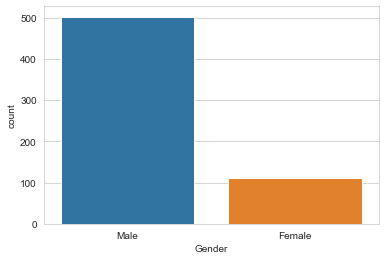

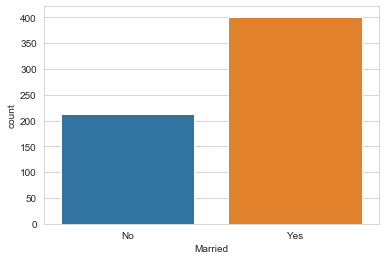

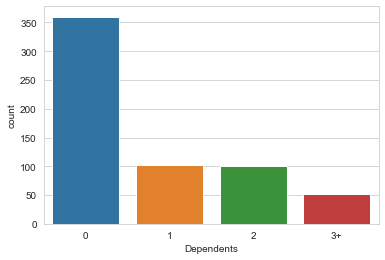

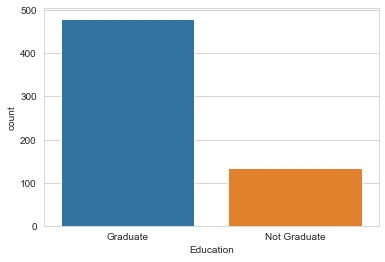

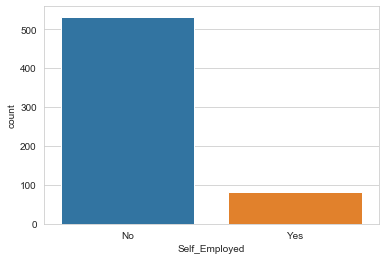

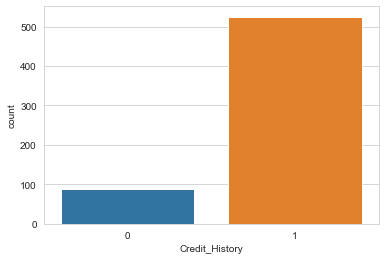

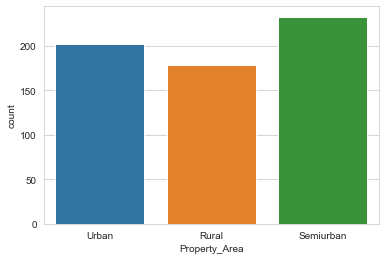

In [32]:
## Plotting the value_counts (countpolot) for better interpretation and visualization of the categories
sns.set_style("whitegrid")
for i in categorical_cols:
    sns.countplot(train[i])
    plt.show()

In [33]:
## plot distributions of the 4 numerical columns : ApplicantIncome	CoapplicantIncome	LoanAmount	Loan_Amount_Term	
numerical_columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

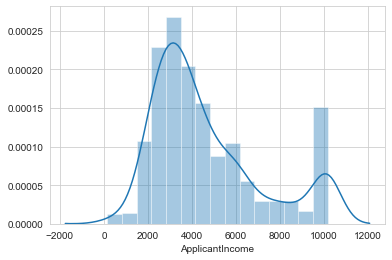

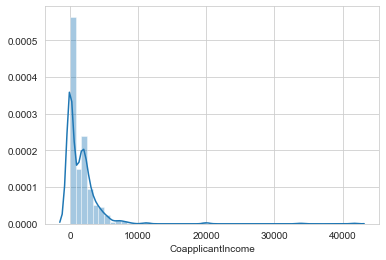

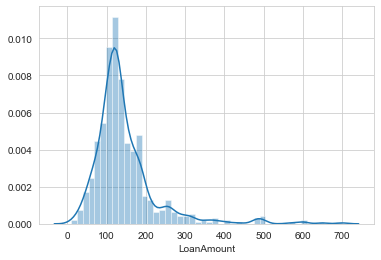

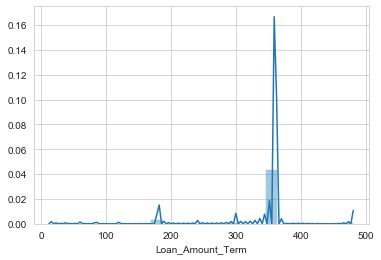

In [34]:
## visualize distributions for each numerical column

for i in numerical_columns:
    sns.distplot(train[i])
    plt.show()                       

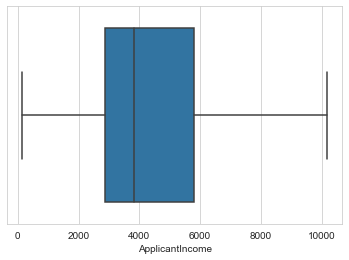

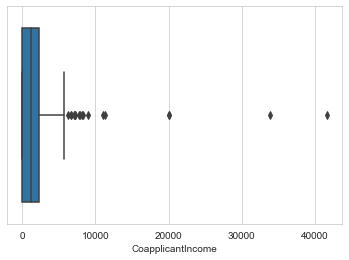

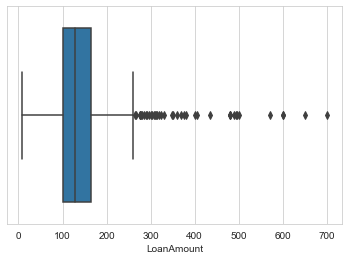

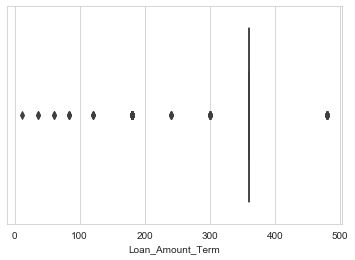

In [35]:
## Checking for OUTLIERS through boxplot

for i in numerical_columns:  # we had already treated outliers for ApplicantIncome while null treatment of LoanAmount col. 
    sns.boxplot(train[i])    # thus we can't see any outliers in ApplicantIncome now
    plt.show()                  

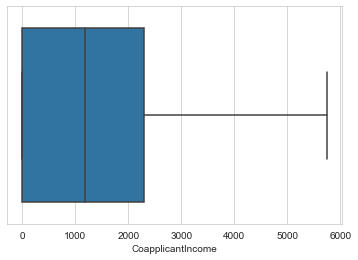

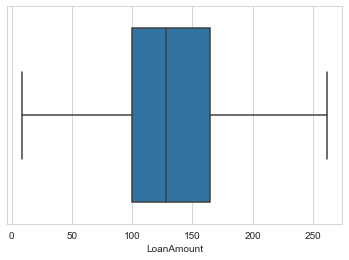

In [36]:
# we had already treated outliers for ApplicantIncome while null treatment of LoanAmount col. thus no outliers visible

## outlier treatment for CoapplicantIncome and LoanAmount
outlier_treatment(train, 'CoapplicantIncome','LoanAmount')

sns.boxplot(train['CoapplicantIncome'])
plt.show()
sns.boxplot(train['LoanAmount'])
plt.show()

In [37]:
## Loan_Amount_Term column ---- Term of loan in months

train['Loan_Amount_Term'].value_counts().sort_index()   

12.0       1
36.0       2
60.0       2
84.0       4
120.0      3
180.0     44
240.0      4
300.0     13
360.0    526
480.0     15
Name: Loan_Amount_Term, dtype: int64

In [38]:
## Checking the lower & upper fence for Loan_Amount_Term

q1,q3 = np.percentile(train['Loan_Amount_Term'],[25,75])
iqr = q3-q1
lower_fence = q1 - (1.5*iqr)
upper_fence = q3 + (1.5*iqr)
print('Lower fence: ', lower_fence,'\nUpper fence ', upper_fence)   

## not a very good idea to treat outliers in this column as all values will be converted to 360 months 
## but this seems to be a very important factor in determining loan status, 
## and hence we'll find a way to use this column to create a new, more useful feature

Lower fence:  360.0 
Upper fence  360.0


In [39]:
## converting Loan_Amount_Term from months to years and creating buckets for the same.

train['Term_Years_Buckets'] = (train['Loan_Amount_Term']/12).apply(lambda x: 10 if x<=10 else 20 if x<=20 
                                                                   else 30 if x<=30 else 40 )   
train['Term_Years_Buckets'].value_counts().sort_index()

10     12
20     48
30    539
40     15
Name: Term_Years_Buckets, dtype: int64

count    614.000000
mean       0.447281
std        0.464743
min        0.025000
25%        0.288889
50%        0.361111
75%        0.505556
max        9.250000
Name: EMI_Amount, dtype: float64

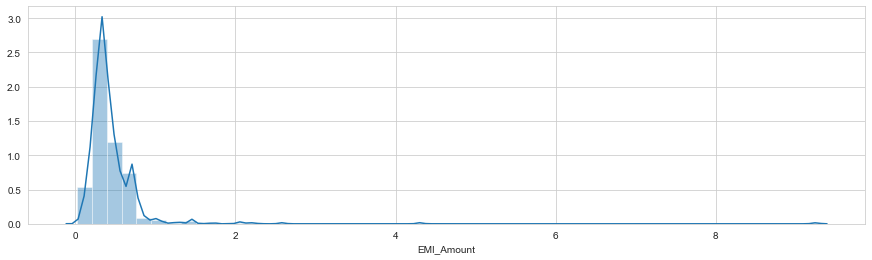

In [40]:
## Using Loan_Amount_Term to calculate monthly Payments to be made, which can be a factor in loan approval
train['EMI_Amount'] = train['LoanAmount']/train['Loan_Amount_Term']

plt.figure(figsize=(15,4))
sns.distplot(train['EMI_Amount']);
train['EMI_Amount'].describe()

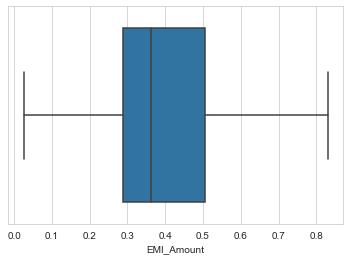

In [130]:
## Treating outliers in EMI_Amount

outlier_treatment(train, 'EMI_Amount')

sns.boxplot(train['EMI_Amount'])
plt.show()

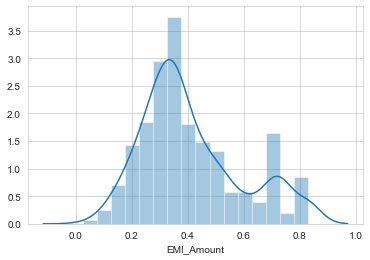

In [141]:
sns.distplot(train['EMI_Amount'])

In [41]:
## BIVARIATE ANALYSIS

In [42]:
categorical_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

In [54]:
categorical_cols.append('Term_Years_Buckets')  ## append Term_Year_Buckets col

categorical_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area',
 'Term_Years_Buckets']

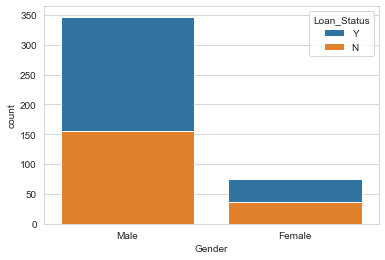

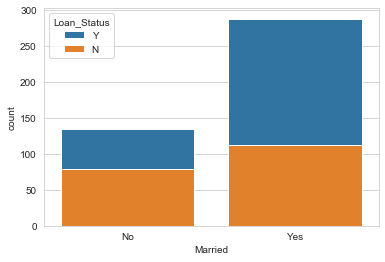

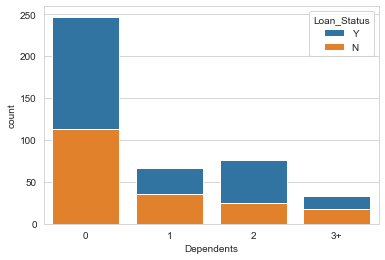

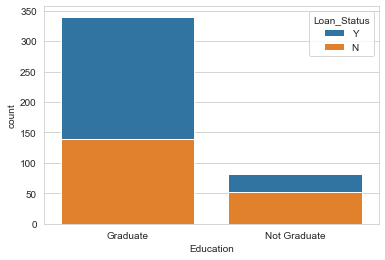

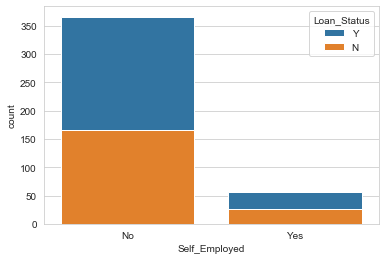

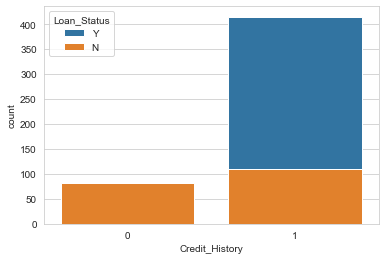

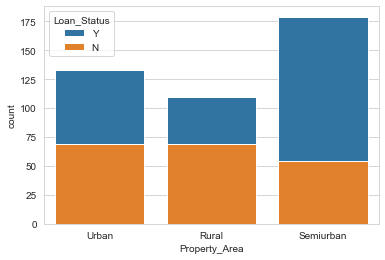

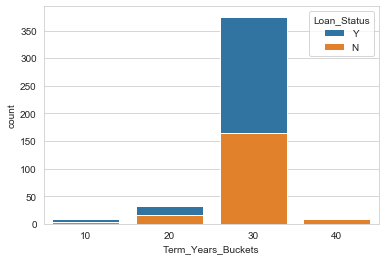

In [58]:
## ANALYZING CATEGORICAL COLUMNS DISTRIBUTION w.r.t TARGET

for i in categorical_cols:
#         sns.countplot(train[i], hue=train['Loan_Status'], dodge=False)
#         plt.show()
        total = float(len(train))
        ax = sns.countplot(x=i, hue="Loan_Status", data=train, dodge=False)             
        plt.show()

        
# ??sns.countplot

In [61]:
numerical_columns.append('EMI_Amount')
numerical_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'EMI_Amount']

In [131]:
## Numerical columns 

train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,EMI_Amount
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,4617.111564,1419.702231,137.365635,342.410423,0.409490
std,2479.851729,1624.605892,55.779749,64.428629,0.179533
min,150.000000,0.000000,9.000000,12.000000,0.025000
25%,2877.500000,0.000000,100.250000,360.000000,0.288889
50%,3812.500000,1188.500000,128.000000,360.000000,0.361111
75%,5795.000000,2297.250000,164.750000,360.000000,0.505556
max,10171.250000,5743.125000,261.500000,480.000000,0.830556


In [133]:
train.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,EMI_Amount
ApplicantIncome,1.000000,-0.228956,0.557953,-0.023926,0.499575
CoapplicantIncome,-0.228956,1.000000,0.265021,-0.029295,0.246880
LoanAmount,0.557953,0.265021,1.000000,0.063612,0.841255
Loan_Amount_Term,-0.023926,-0.029295,0.063612,1.000000,-0.447791
EMI_Amount,0.499575,0.246880,0.841255,-0.447791,1.000000


In [95]:
train.dtypes

Loan_ID                object
Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome       float64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History         object
Property_Area          object
Loan_Status            object
Term_Years_Buckets     object
EMI_Amount            float64
dtype: object

In [94]:
train['Term_Years_Buckets'] = train['Term_Years_Buckets'].astype('object')
train['Term_Years_Buckets'].dtype

dtype('O')

## Splitting features and target

In [134]:
X = train.drop(['Loan_Status','Loan_ID'], axis=1)
y = train['Loan_Status']

X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Term_Years_Buckets,EMI_Amount
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1,Urban,30,0.355556
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1,Rural,30,0.355556
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1,Urban,30,0.183333
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1,Urban,30,0.333333
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1,Urban,30,0.391667


In [97]:
categorical_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area',
 'Term_Years_Buckets']

## Encoding the categorical columns

In [135]:
## GET DUMMIES

X = pd.get_dummies(X, drop_first=True)
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,EMI_Amount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1,Property_Area_Semiurban,Property_Area_Urban,Term_Years_Buckets_20,Term_Years_Buckets_30,Term_Years_Buckets_40
0,5849.0,0.0,128.0,360.0,0.355556,1,0,0,0,0,0,0,1,0,1,0,1,0
1,4583.0,1508.0,128.0,360.0,0.355556,1,1,1,0,0,0,0,1,0,0,0,1,0
2,3000.0,0.0,66.0,360.0,0.183333,1,1,0,0,0,0,1,1,0,1,0,1,0
3,2583.0,2358.0,120.0,360.0,0.333333,1,1,0,0,0,1,0,1,0,1,0,1,0
4,6000.0,0.0,141.0,360.0,0.391667,1,0,0,0,0,0,0,1,0,1,0,1,0


## Train-Test Split

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

## Model training

In [151]:
## Logistic Regression - Baseline model

from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression() 
logistic_classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [152]:
# train accuracy
print('TRAIN ACCURACY: ', logistic_classifier.score(X_train, y_train))  

# test accuracy
print('TEST ACCURACY : ', logistic_classifier.score(X_val, y_val))          


TRAIN ACCURACY:  0.8275058275058275
TEST ACCURACY :  0.772972972972973


[[ 22  37]
 [  5 121]]
              precision    recall  f1-score   support

           N       0.81      0.37      0.51        59
           Y       0.77      0.96      0.85       126

    accuracy                           0.77       185
   macro avg       0.79      0.67      0.68       185
weighted avg       0.78      0.77      0.74       185



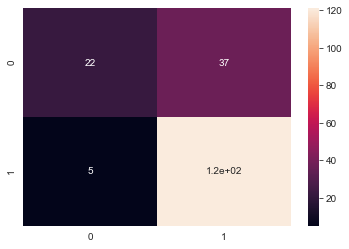

In [153]:
y_pred = logistic_classifier.predict(X_val)

from sklearn import metrics

print(metrics.confusion_matrix(y_val,y_pred ))
sns.heatmap(metrics.confusion_matrix(y_val,y_pred ),annot=True)
print(metrics.classification_report(y_val, y_pred))

## It seems to be a case of class imbalance as the model has not acknowledged Loan_Status = N

In [146]:
??logistic_classifier

In [156]:
## Using GridSearchCV for finding best hyper-parameters

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 0.2, 0.5, 1.0, 1.5, 2.0], 'max_iter': [300, 500, 800],
              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  

grid = GridSearchCV(LogisticRegression(), param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.5, 1.0, 1.5, 2.0],
                         'max_iter': [300, 500, 800],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [160]:
## Print best parameters given by GridSearchCV

print('Best Paramaters: ', grid.best_params_, '\n     Best Score: ', grid.best_score_)

Best Paramaters:  {'C': 1.0, 'max_iter': 300, 'solver': 'newton-cg'} 
     Best Score:  0.8298368298368298


In [164]:
logistic_classifier = LogisticRegression(C= 1.0, max_iter= 300, solver= 'newton-cg') 
logistic_classifier.fit(X_train,y_train)

# train accuracy
print('TRAIN ACCURACY: ', logistic_classifier.score(X_train, y_train))  

# test accuracy
print('TEST ACCURACY : ', logistic_classifier.score(X_val, y_val))                  ## No Improvement in accuracy

TRAIN ACCURACY:  0.8275058275058275
TEST ACCURACY :  0.772972972972973


In [166]:
## Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=50, max_features = 'sqrt', n_jobs=-1, verbose = 1)

rf_model.fit(X_train, y_train)

# train accuracy
print('TRAIN ACCURACY: ', logistic_classifier.score(X_train, y_train))  

# test accuracy
print('TEST ACCURACY : ', logistic_classifier.score(X_val, y_val))   ## Still the same accuracy as logistic_classifier

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


TRAIN ACCURACY:  0.8275058275058275
TEST ACCURACY :  0.772972972972973


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


## Deploy the model onto the test dataset and export the submission file for hackathon submission

In [201]:
# import test dataset

test = pd.read_csv('test.csv')
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [202]:
## Treating the anomalies in test data like we did for train
display(test.info(),test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


None

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [203]:
## Replacing nulls with mode in 'Gender', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term'

for i in ['Gender', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']:
    test[i].fillna(test[i].mode()[0], inplace=True)
    
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           5
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [204]:
## Replacing Loan_Amount with median

test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)

test.isnull().sum()   ## All nulls are treated

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [205]:
# converting 'Credit_History' column to object type as it is a categorical column
test['Credit_History'] = test['Credit_History'].apply(lambda x: '1' if x==1.0 else '0' if x==0.0 else x)
test['Credit_History'].dtype   ## 'O' stands for object type

dtype('O')

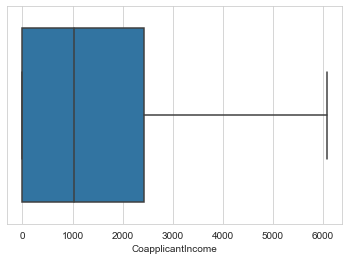

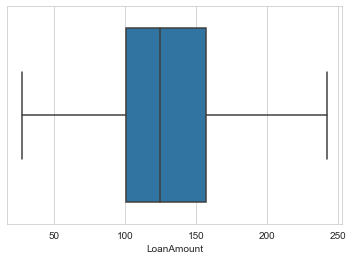

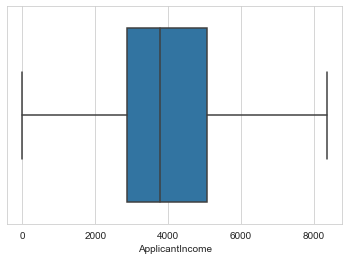

In [206]:
outlier_treatment(test, 'CoapplicantIncome','LoanAmount', 'ApplicantIncome')

for i in ['CoapplicantIncome','LoanAmount', 'ApplicantIncome']:
    sns.boxplot(test[i])
    plt.show()


In [207]:
## converting Loan_Amount_Term from months to years and creating buckets for the same.

test['Term_Years_Buckets'] = (test['Loan_Amount_Term']/12).apply(lambda x: 10 if x<=10 else 20 if x<=20 
                                                                   else 30 if x<=30 else 40 )   
test['Term_Years_Buckets'].value_counts().sort_index()

10      8
20     26
30    325
40      8
Name: Term_Years_Buckets, dtype: int64

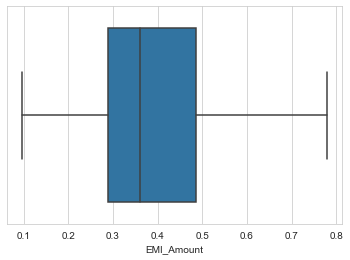

In [208]:
test['EMI_Amount'] = test['LoanAmount']/test['Loan_Amount_Term']

outlier_treatment(test, 'EMI_Amount')

# sns.distplot(test['EMI_Amount'])
sns.boxplot(test['EMI_Amount'])

In [210]:
test['Term_Years_Buckets'] = test['Term_Years_Buckets'].astype('object')
test['Term_Years_Buckets'].dtype

dtype('O')

In [197]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Term_Years_Buckets,EMI_Amount
0,LP001015,Male,Yes,0,Graduate,No,5720.0,0.0,110.0,360,1,Urban,30,0.305556
1,LP001022,Male,Yes,1,Graduate,No,3076.0,1500.0,126.0,360,1,Urban,30,0.350000
2,LP001031,Male,Yes,2,Graduate,No,5000.0,1800.0,208.0,360,1,Urban,30,0.577778
3,LP001035,Male,Yes,2,Graduate,No,2340.0,2546.0,100.0,360,1,Urban,30,0.277778
4,LP001051,Male,No,0,Not Graduate,No,3276.0,0.0,78.0,360,1,Urban,30,0.216667


In [217]:
X_test = test.drop('Loan_ID', axis=1)
X_test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Term_Years_Buckets,EMI_Amount
0,Male,Yes,0,Graduate,No,5720.0,0.0,110.0,360.0,1,Urban,30,0.305556
1,Male,Yes,1,Graduate,No,3076.0,1500.0,126.0,360.0,1,Urban,30,0.350000
2,Male,Yes,2,Graduate,No,5000.0,1800.0,208.0,360.0,1,Urban,30,0.577778
3,Male,Yes,2,Graduate,No,2340.0,2546.0,100.0,360.0,1,Urban,30,0.277778
4,Male,No,0,Not Graduate,No,3276.0,0.0,78.0,360.0,1,Urban,30,0.216667


In [218]:
## GET DUMMIES

X_test = pd.get_dummies(X_test, drop_first=True)
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,EMI_Amount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1,Property_Area_Semiurban,Property_Area_Urban,Term_Years_Buckets_20,Term_Years_Buckets_30,Term_Years_Buckets_40
0,5849.0,0.0,128.0,360.0,0.355556,1,0,0,0,0,0,0,1,0,1,0,1,0
1,4583.0,1508.0,128.0,360.0,0.355556,1,1,1,0,0,0,0,1,0,0,0,1,0
2,3000.0,0.0,66.0,360.0,0.183333,1,1,0,0,0,0,1,1,0,1,0,1,0
3,2583.0,2358.0,120.0,360.0,0.333333,1,1,0,0,0,1,0,1,0,1,0,1,0
4,6000.0,0.0,141.0,360.0,0.391667,1,0,0,0,0,0,0,1,0,1,0,1,0


In [220]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [226]:
test_pred = logistic_classifier.predict(X_test)     ## predict Loan_Status for test dataset
# test_pred

In [228]:
test.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Term_Years_Buckets,EMI_Amount
0,LP001015,Male,Yes,0,Graduate,No,5720.0,0.0,110.0,360.0,1,Urban,30,0.305556
1,LP001022,Male,Yes,1,Graduate,No,3076.0,1500.0,126.0,360.0,1,Urban,30,0.350000


In [229]:
test['Loan_Status'] = test_pred  ## adding test 'Loan_Status' predictions as a new column in test dataframe
test.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Term_Years_Buckets,EMI_Amount,Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720.0,0.0,110.0,360.0,1,Urban,30,0.305556,Y
1,LP001022,Male,Yes,1,Graduate,No,3076.0,1500.0,126.0,360.0,1,Urban,30,0.350000,Y


In [231]:
submission_df = test[['Loan_ID','Loan_Status']]       ## preparing a dataframe for final submission
submission_df.head(2)

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y


In [232]:
submission_df.to_csv('submission_1.csv', index=False)   ## export the output to a csv file for submission on 'Analytics Vidhya'